In [1]:
# myfile_cameras = '/home/shivani/Documents/BuildingInspection/SFM/sparse/0/cameras.bin'
# myfile_cameras = '/home/shivani/Documents/BuildingInspection/SFM/sparse/0/cameras.bin'
# myfile_cameras = '/home/shivani/Documents/BuildingInspection/SFM/sparse/0/cameras.bin'

# import numpy as np

# dtype = np.dtype('B')
# try:
#     with open(myfile_cameras, "rb") as f:
#         numpy_data = np.fromfile(f,dtype)
#     print(numpy_data)
# except IOError:
#     print('Error While Opening the file!')    

# print(numpy_data.shape)
# for i in range(numpy_data.shape[0]):
#     print(i, numpy_data[i])

In [2]:
import numpy as np
import open3d as o3d
import sympy as sp
import cv2
import csv
import sys
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import copy

'''
cameras:
CAMERA_ID, MODEL, WIDTH, HEIGHT, PARAMS[single focal length, principal point x, principlal point y, distortion coeff]
-----------
images: (Image list with two lines of data per image:)
IMAGE_ID, QW, QX, QY, QZ, TX, TY, TZ, CAMERA_ID, NAME
POINTS2D[] as (X, Y, POINT3D_ID)

key 2d points used in the image are in POINTS2D and each of these points are related to a 3d point
if POINT3D_ID = -1, it means that 2d point is not used in reconstruction
------------
points3D: (3D point list with one line of data per point:)
POINT3D_ID, X, Y, Z, R, G, B, ERROR, TRACK[] as (IMAGE_ID, POINT2D_IDX)

The error is given in pixels of reprojection error 
and is only updated after global bundle adjustment

camera intrinsic matrix = [[f, 0 ,px],
                        [0, f, py],
                        [0, 0, 1]]

'''

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


'\ncameras:\nCAMERA_ID, MODEL, WIDTH, HEIGHT, PARAMS[single focal length, principal point x, principlal point y, distortion coeff]\n-----------\nimages: (Image list with two lines of data per image:)\nIMAGE_ID, QW, QX, QY, QZ, TX, TY, TZ, CAMERA_ID, NAME\nPOINTS2D[] as (X, Y, POINT3D_ID)\n\nkey 2d points used in the image are in POINTS2D and each of these points are related to a 3d point\nif POINT3D_ID = -1, it means that 2d point is not used in reconstruction\n------------\npoints3D: (3D point list with one line of data per point:)\nPOINT3D_ID, X, Y, Z, R, G, B, ERROR, TRACK[] as (IMAGE_ID, POINT2D_IDX)\n\nThe error is given in pixels of reprojection error \nand is only updated after global bundle adjustment\n\ncamera intrinsic matrix = [[f, 0 ,px],\n                        [0, f, py],\n                        [0, 0, 1]]\n\n'

### Methodology

#### Method 1

Consider an image for which we want to get 2d to 3d(sparse point cloud) pixel correspondences <br>
Go to images.txt and find the image by its name. <br>
From that row in images.txt, Get transformation matrix and corresponding camera ID <br>
Use the camera ID and Get camera intrinsic matrix K from cameras.txt <br>
We can get Projection Matrix (from 2d image frame to 3d world frame) using P = KT <br>
Homogenise P and Get P_Inverse <br> 
we have the row and column of the pixel we are trying to convert to 3D Point <br>
we have depth information for each pixel of each image from depth maps (from dense reconstruction) <br>
depth = depthmap[row,col] <br>
3D Point(in XYZ) = P_Inverse * [col * depth, row * depth, depth, 1] <br>

match The calculated 3D point to the real 3D Pt value found in the .ply file (read .ply also) <br>

project entire point cloud on an image and check
<br> ----------------- <br>

#### Method 2
In images.txt, we have the 2d key points and id of 3d point to which they map <br>

visualise used feature points in 2d image (show on image), their 3d points in o3d <br>
project these 3d points on to the image and calculate reprojection error to check <br>

find NN of mouse selected coords from these feature points, plot NN (show on image) and plot 3d points corr to these NN feature points in o3d <br>
(highlight in colmap if possible)

<br> <br>

<!-- select required 3d points from colmap(sparse recon) and project them to their corresponding 2d images -->


In [3]:
def quaternion_rotation_matrix(Q, T):
    q0 = Q[0]
    q1 = Q[1]
    q2 = Q[2]
    q3 = Q[3]
    
    tx = T[0]
    ty = T[1]
    tz = T[2]
    
    # First row of the rotation matrix
    r00 = 2 * (q0 * q0 + q1 * q1) - 1
    r01 = 2 * (q1 * q2 - q0 * q3)
    r02 = 2 * (q1 * q3 + q0 * q2)
     
    # Second row of the rotation matrix
    r10 = 2 * (q1 * q2 + q0 * q3)
    r11 = 2 * (q0 * q0 + q2 * q2) - 1
    r12 = 2 * (q2 * q3 - q0 * q1)
     
    # Third row of the rotation matrix
    r20 = 2 * (q1 * q3 - q0 * q2)
    r21 = 2 * (q2 * q3 + q0 * q1)
    r22 = 2 * (q0 * q0 + q3 * q3) - 1
     
    # 3x3 rotation matrix
    rot_matrix = np.array([[r00, r01, r02],
                           [r10, r11, r12],
                           [r20, r21, r22]])
    
    translation_matrix = np.array([[tx],
                                   [ty],
                                   [tz]])
                            
    transformation_matrix = getTransformationMatrix(rot_matrix, translation_matrix)
    return rot_matrix, translation_matrix, transformation_matrix

def getTransformationMatrix(R, t):
    # given Rotation matrix, R and translation matrix, t
    # return the transformation matrix describing the combined motion, T
    augment = np.array([0, 0, 0, 1]) # Converting to homogeneous matrix
    R = np.array(R)
    t = np.array(t)
    if (t.shape == (3,)):
        t = t.reshape((3,1))
    T = np.hstack((R, t))
    T = np.vstack((T, augment))
    assert(T.shape, (4,4))
    return T

def getCameraIntrinsicMatrix(params):
    # focal length, principlal point x, principal point y, distortion param 
    K = np.identity(3) # K: Callibration Matrix
    K[0, 0] = params[0]
    K[1, 1] = params[0]
    K[0, 2] = params[1]
    K[1, 2] = params[2]
    return K


<>:48: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:48: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:48: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<ipython-input-3-75858e46cd7d>:48: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(T.shape, (4,4))


In [4]:
myfile_cameras = '/home/shivani/Documents/BuildingInspection/SFM/sparse/0/cameras.txt'
myfile_images = '/home/shivani/Documents/BuildingInspection/SFM/sparse/0/images.txt'
myfile_points3D = '/home/shivani/Documents/BuildingInspection/SFM/sparse/0/points3D.txt'

imname = '00030.jpg'
imfile = '/home/shivani/Documents/BuildingInspection/data/' + imname
img = cv2.imread(imfile)
cv2.imshow('image',img)

coordinates = []
def click_event(event, x, y, flags, params):
  
    # checking for left mouse clicks
    if event == cv2.EVENT_LBUTTONDOWN:
        print(x, ' ', y)  
        cv2.imshow('image', img)
        coordinates.append([x,y])
  
    # checking for right mouse clicks     
    if event==cv2.EVENT_RBUTTONDOWN:
        print(x, ' ', y)
        cv2.imshow('image', img)
        coordinates.append([x,y])

# setting mouse hadler for the image
# and calling the click_event() function
cv2.setMouseCallback('image', click_event)

# wait for a key to be pressed to exit
cv2.waitKey(0)

# close the window
cv2.destroyAllWindows()

108   41
190   108
264   166
356   236
469   323
579   425
650   259
805   387
972   486
1194   497


In [5]:
print(len(coordinates))
# print(coordinates)

# coordinates of rooftop edges
# coordinates = [[621, 440], [483, 327], [357, 231], [219, 108], [88, 10], [574, 2], [660, 54], [789, 110], [867, 168], [957, 207], [1055, 163], [1184, 241], [1292, 189], [1292, 433], [1093, 532]]

10


In [6]:
###### parse sfm files -- points3D.txt, cameras.txt and images.txt
csv.field_size_limit(sys.maxsize)

with open(myfile_points3D, 'r') as fd:
    reader = csv.reader(fd)
    rowArr = []
    points_3d_ids = []
    xyz_coords = []
    rgb_vals = []
    reproj_errs = []
    tracks = []
    for i,line in enumerate(reader):
        rowArr.append(list(map(float, line[0].split())))
        points_3d_ids.append(line[0].split()[0])
        xyz_coords.append(line[0].split()[1:4])
        rgb_vals.append(line[0].split()[4:7])
        reproj_errs.append(line[0].split()[7])
        tracks.append(line[0].split()[8:]) #(IMAGE_ID, POINT2D_IDX)
        
twoDPoints = rowArr[1]
print('No. of 2DPoints: ', len(twoDPoints))
print(twoDPoints)
print(len(points_3d_ids))

No. of 2DPoints:  20
[370410.0, 0.237232, -0.440943, 5.26491, 121.0, 122.0, 117.0, 3.28102, 160.0, 1610.0, 161.0, 907.0, 155.0, 3552.0, 152.0, 3298.0, 159.0, 4882.0, 157.0, 6437.0]
263453


In [7]:
csv.field_size_limit(sys.maxsize)

with open(myfile_cameras, 'r') as fd2:
    reader2 = csv.reader(fd2)
    rowArr2 = []
    camera_ids = []
    width_cam = 0
    height_cam = 0
    params = [] # f, cx, cy, dist
    for i,line in enumerate(reader2):
#         rowArr2.append(list(map(float, line[0].split())))
        rowArr2.append(list(line[0].split()))
        camera_ids.append(line[0].split()[0])
        params.append(line[0].split()[4:]) #(IMAGE_ID, POINT2D_IDX)
        if (i == 0):
            width_cam = line[0].split()[2]
            height_cam = line[0].split()[3]
            
print(len(camera_ids))
print(rowArr2[1])

400
['399', 'SIMPLE_RADIAL', '1920', '1080', '1534.87', '960', '540', '0.00945933']


In [8]:
csv.field_size_limit(sys.maxsize)

with open(myfile_images, 'r') as fd3:
    reader3 = csv.reader(fd3)
    rowArr3 = []
    rowArr3_2 = []
    image_ids = []
    Quats = []
    Ts = []
    camera_ids_of_images = []
    image_names = []
    
#     keypoint_coords_all = [] # with 3d point id
#     keypoint_coords_used = [] # with 3d point id
    keypoints_x = []
    keypoints_y = []
    inds_3d_point = []
    
    for i,line in enumerate(reader3):
#         rowArr3.append(list(map(float, line[0].split())))
#         print('i',i)
        if (i == 0):
            width_img = line[0].split()[2]
            height_img = line[0].split()[3]
        if(i%2 == 0): # lines 0,2,4 ...
            rowArr3.append(list(line[0].split()))
            image_ids.append(line[0].split()[0])
            Quats.append(line[0].split()[1:5])
            Ts.append(line[0].split()[5:8])
            camera_ids_of_images.append(line[0].split()[8])
            image_names.append(line[0].split()[9])
        elif(i%2 == 1):
            rowArr3_2.append(list(line[0].split()))
            keypoints_x.append(line[0].split()[0::3])
            keypoints_y.append(line[0].split()[1::3])
            inds_3d_point.append(line[0].split()[2::3])
# print(len(camera_ids_of_images))
# print(rowArr3[1])
# print(rowArr3[2])

In [9]:
width_img

'0.0034786'

In [10]:
## filter un-used keypoints ie remove 2d points with 3d point index -1

inds_used = []
keypoints_x_used = []
keypoints_y_used = []

# inds_3d_point = list(map(int,inds_3d_point))
# keypoints_x = list(map(float,keypoints_x))
# keypoints_y = list(map(float,keypoints_y))
# keypoints_x = list(map(round,keypoints_x))
# keypoints_y = list(map(round,keypoints_y))

for ind_ in range(len(inds_3d_point)):
    inds_used_one_image = []
    keypoints_x_used_one_image = []
    keypoints_y_used_one_image = []
    
#     for _ind in range(len(list(map(int,inds_3d_point[ind_])))):
    for _ind in range(len(inds_3d_point[ind_])):

#         if list(map(int,inds_3d_point[ind_]))[_ind] != -1:
        if inds_3d_point[ind_][_ind] != '-1':
#             inds_used_one_image.append(list(map(int,inds_3d_point[ind_]))[_ind])
#             keypoints_x_used_one_image.append(list(map(float,keypoints_x[ind_]))[_ind])
#             keypoints_y_used_one_image.append(list(map(float,keypoints_y[ind_]))[_ind])
            inds_used_one_image.append(inds_3d_point[ind_][_ind])
            keypoints_x_used_one_image.append(keypoints_x[ind_][_ind])
            keypoints_y_used_one_image.append(keypoints_y[ind_][_ind])
            
    keypoints_x_used.append(keypoints_x_used_one_image)
    keypoints_y_used.append(keypoints_y_used_one_image)
    inds_used.append(inds_used_one_image)

print(len(keypoints_x_used))
print(len(keypoints_y_used))
print(len(inds_used))

400
400
400


In [11]:
print(inds_used[0][0])

33542


(1073, 1908)
[[0.01034692 0.01035497 0.01031041 ... 0.01003552 0.01003572 0.01001256]
 [0.01008684 0.0100825  0.01007496 ... 0.00998945 0.01005538 0.01002296]
 [0.01002962 0.0100237  0.01001676 ... 0.01000165 0.01016496 0.01012771]
 ...
 [0.00221691 0.00221847 0.00222078 ... 0.00396218 0.01013548 0.015751  ]
 [0.00221625 0.0022318  0.00428388 ... 0.00394058 0.00382388 0.00367639]
 [0.00221625 0.00437841 0.00432118 ... 0.00415031 0.00408038 0.00415187]]
0.004795331
0.0175752


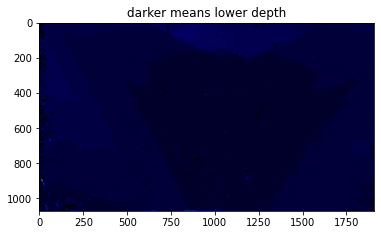

In [12]:
###### reading depth maps ########
# function from colmap repository
def read_array_depthmap(path):
    with open(path, "rb") as fid:
        width, height, channels = np.genfromtxt(fid, delimiter="&", max_rows=1,
                                                usecols=(0, 1, 2), dtype=int)
        fid.seek(0)
        num_delimiter = 0
        byte = fid.read(1)
        while True:
            if byte == b"&":
                num_delimiter += 1
                if num_delimiter >= 3:
                    break
            byte = fid.read(1)
        array = np.fromfile(fid, np.float32)
    array = array.reshape((width, height, channels), order="F")
    return np.transpose(array, (1, 0, 2)).squeeze()

# depthmap_path = '/home/shivani/Documents/depth_maps/' + '00030.jpg.geometric.bin'
depthmap_path = '/home/shivani/Documents/depth_maps/' + '00030.jpg.photometric.bin'

depth_arr = read_array_depthmap(depthmap_path)
print(depth_arr.shape)

max_ind = np.unravel_index(depth_arr.argmax(), depth_arr.shape)
depth_arr_normalised = depth_arr/depth_arr[max_ind[0],max_ind[1]]
print(depth_arr_normalised)

from PIL import Image
from matplotlib import cm
im_depth = Image.fromarray(np.uint8(cm.gist_earth(depth_arr_normalised)*255))
# im_depth = Image.fromarray(np.uint8(cm.gist_gray(depth_arr_normalised)*255))
im_depth.save('depth_arr_img.png')
plt.imshow(im_depth)
plt.title('darker means lower depth')
print(depth_arr_normalised[500][1000])
print(depth_arr_normalised[100][1100])


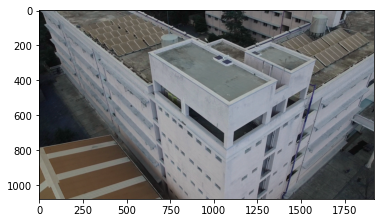

In [13]:
plt.imshow(img)

In [14]:
imid = image_names.index(imname)
Q_imid = Quats[imid]
t_imid = Ts[imid]
rot_mat_imid, trans_mat_imid, RT_imid = quaternion_rotation_matrix(list(map(float,Q_imid)), list(map(float,t_imid)))
K_imid = getCameraIntrinsicMatrix(list(map(float,params[imid])))

P_imid = np.matmul(K_imid,RT_imid[:3,:]) #getProjMat
P_imid = np.vstack((P_imid,[0, 0, 0, 1])) 
inv_P_temp_imid = np.linalg.pinv(P_imid)
inv_P_imid = inv_P_temp_imid[:3,:] #getInvProjMat


### Method 2

In [15]:
################### check 3d points of 2d image pixels ##############
ind_list_3d_used_imid = inds_used[imid]

serial_num_3dpoints = []
for i in ind_list_3d_used_imid: 
    serial_num_3dpoints.append(points_3d_ids.index(i))

xyz_3dpoints = [xyz_coords[i] for i in serial_num_3dpoints] 
rgb_3dpoints = [rgb_vals[i] for i in serial_num_3dpoints]

rgb_3dpoints = np.array(rgb_3dpoints).astype(float)
xyz_3dpoints = np.array(xyz_3dpoints).astype(float)


In [16]:
print('ind_list_3d_used_imid',len(ind_list_3d_used_imid))
print('serial_num_3dpoints', len(serial_num_3dpoints))
print('xyz_3dpoints', len(xyz_3dpoints))
print('rgb_3dpoints', len(rgb_3dpoints))

print(P_imid.shape)
print(K_imid.shape)
print(RT_imid)
print(inv_P_temp_imid)

type(keypoints_y_used)
# fig3 = plt.imshow(img)
print(min(keypoints_y_used[imid]))
print(min(keypoints_x_used[imid]))
print(imid)

print('serial_num_3dpoints', serial_num_3dpoints[0])
print('xyz_3dpoints', xyz_3dpoints[0])
print('rgb_3dpoints', rgb_3dpoints[0])


ind_list_3d_used_imid 5978
serial_num_3dpoints 5978
xyz_3dpoints 5978
rgb_3dpoints 5978
(4, 4)
(3, 3)
[[ 0.99870343 -0.03514164  0.03684319 -1.04439   ]
 [ 0.03534443  0.99936379 -0.00486705 -2.30546   ]
 [-0.0366487   0.00616293  0.99930966  3.31341   ]
 [ 0.          0.          0.          1.        ]]
[[ 6.52490874e-04  2.30918580e-05 -6.75509506e-01  1.24595208e+00]
 [-2.29593699e-05  6.52922311e-04 -3.24374124e-01  2.24686931e+00]
 [ 2.40710547e-05 -3.17982628e-06  9.77917650e-01 -3.28386177e+00]
 [-1.35603319e-19  2.52160992e-19 -8.64572104e-18  1.00000000e+00]]
0.83979
10.9517
152
serial_num_3dpoints 100762
xyz_3dpoints [0.0685983 2.13247   1.64905  ]
rgb_3dpoints [187. 179. 177.]


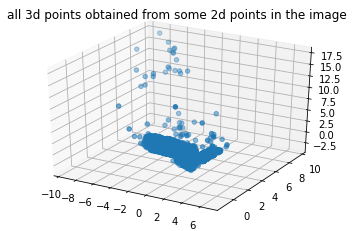

INFO - 2022-02-18 08:23:28,365 - category - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO - 2022-02-18 08:23:28,388 - category - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO - 2022-02-18 08:23:28,413 - category - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO - 2022-02-18 08:23:28,435 - category - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


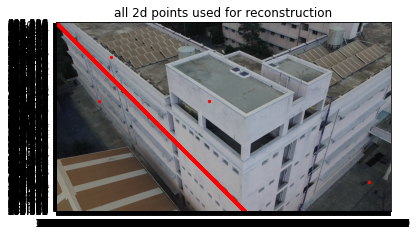

In [17]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(xyz_3dpoints[:,0], xyz_3dpoints[:,1], xyz_3dpoints[:,2], cmap='Greens');
plt.title('all 3d points obtained from some 2d points in the image')
plt.show(fig)

fig2 = plt.figure()
plt.scatter(keypoints_x_used[imid],keypoints_y_used[imid],c='r', s=5)
im = plt.imshow(img)
plt.title('all 2d points used for reconstruction')
plt.show(fig2)


In [ ]:
# Pass xyz to Open3D.o3d.geometry.PointCloud and visualize
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(xyz_3dpoints)
o3d.io.write_point_cloud("sync.ply", pcd)
# Load saved point cloud and visualize it
pcd_load = o3d.io.read_point_cloud("sync.ply")
o3d.visualization.draw_geometries([pcd_load])


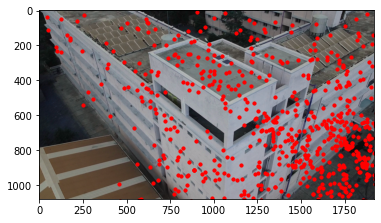

In [19]:
########### Project 3d points obtained from key points in this image back to the image and get reprojection error
proj_2d_points = []
reprojection_err_arr = []
xyz_3dpoints = np.array(xyz_3dpoints)
xyz_3dpoints_homo = np.column_stack((xyz_3dpoints, np.ones((xyz_3dpoints.shape[0],1))))

for i in range(len(xyz_3dpoints)):
#     proj_2d_points.append(K_imid@RT_imid@xyz_3dpoints[i])
#     point_2d_ = P_imid@xyz_3dpoints_homo[i]
    point_2d_ = P_imid[:3,:].astype(float)@xyz_3dpoints_homo[i].astype(float)
    proj_2d_points.append(point_2d_)
    point_2d_from_images_txt = np.array([keypoints_x_used[imid][i],keypoints_y_used[imid][i],1]).astype(float)
    #check if indices are properly mapped
    
#     reprojection_err_arr.append(np.linalg.norm(point_2d_ - point_2d_from_images_txt))
#     reprojection_err_arr.append(np.linalg.norm((point_2d_/point_2d_[2])[0:-1] - point_2d_from_images_txt[0:-1]))
    reprojection_err_arr.append(np.linalg.norm(point_2d_ - point_2d_from_images_txt))
    
# print(proj_2d_points)
proj_2d_points = np.array(proj_2d_points)

fgp = plt.figure()
img_copy = copy.deepcopy(img)
plt.scatter(proj_2d_points[:,0],proj_2d_points[:,1],c='r', s=10)
impl = plt.imshow(img_copy)
plt.show()


In [20]:
# print(point_2d_)
# print(np.array(point_2d_from_images_txt)[0])
# print(np.array([keypoints_x_used[0],keypoints_y_used[0],1]))
# print(keypoints_x_used)
# print(type(xyz_3dpoints))

ind = 0
print('2d pixel coord: ',keypoints_x_used[imid][ind],keypoints_y_used[imid][ind])
print('3d coordinate: ',xyz_3dpoints[ind])
print('3d point id: ',points_3d_ids.index(ind_list_3d_used_imid[ind]))

# print(len(reprojection_err_arr))
print('mean reproj err from calculation: ', np.mean(reprojection_err_arr))
print('reprojection error in pixels from txt files: ', reproj_errs[imid])
# print(np.linalg.norm(np.mean(reprojection_err_arr) - float(reproj_errs[imid])))
print('difference: ',np.mean(reprojection_err_arr) - float(reproj_errs[imid]))

2d pixel coord:  654.686 482.818
3d coordinate:  [0.0685983 2.13247   1.64905  ]
3d point id:  100762
mean reproj err from calculation:  3362.186431459219
reprojection error in pixels from txt files:  0.0180835
difference:  3362.168347959219


### Method 1

In [21]:
# num_2d_imid = len(keypoints_x[imid][:])
# row_arr = list(map(float,keypoints_x_used[imid][:])) #key points used in recon
# col_arr = list(map(float,keypoints_y_used[imid][:])) #key points used in recon
# # row_arr = keypoints_x_used[imid][:]
# # col_arr = keypoints_y_used[imid][:]
# # print(len(row_arr))
# # print(len(col_arr))
# print('row_arr[0],col_arr[0]', row_arr[0],col_arr[0])
# # print(row_arr[1],col_arr[1])


row_arr = np.floor(np.array(keypoints_x_used[imid]).astype(float)).astype(int) # height 1000 
# depth_arr.shape (1073, 1908)  # (height, width)
col_arr = np.floor(np.array(keypoints_y_used[imid]).astype(float)).astype(int) # width 1900
# print('np.max(row_arr)',np.max(row_arr))
# print('np.max(col_arr)',np.max(col_arr))

# row_arr = [row_arr[i] for i in row_arr if i < depth_arr.shape[0]]
# col_arr = [col_arr[i] for i in col_arr if i < depth_arr.shape[1]]
# print('depth_arr.shape',depth_arr.shape)
row_arr_inds = [i for i in range(len(row_arr)) if row_arr[i] >= depth_arr.shape[1]]
row_arr = np.delete(row_arr, row_arr_inds)
col_arr = np.delete(col_arr, row_arr_inds)
print('row_arr_inds',row_arr_inds)

col_arr_inds = [i for i in range(len(col_arr)) if col_arr[i] >= depth_arr.shape[0]]
print('col_arr_inds',col_arr_inds)
row_arr = np.delete(row_arr, col_arr_inds)
col_arr = np.delete(col_arr, col_arr_inds)

# print(np.max(row_arr))
# print(np.max(col_arr))

# print(len(row_arr))
# print(len(col_arr))
points_calculated_3d = []

# for all 2d pixels used in recon in the image -- not doing because of subpixel precision
# going for selected coordinates
print('depth_arr.shape',depth_arr.shape)
for i in range(np.minimum(len(row_arr),len(col_arr))):
# for i in range(len(keypoints_x_used[imid])):
# for i in range(len(coordinates)):

#     row = round(row_arr[i])
#     col = round(col_arr[i])
#     depth = depthmap[row, col] #row, col are 2d coordinates of a point in the image
    row = row_arr[i]
    col = col_arr[i]
#     row = coordinates[i][0]
#     col = coordinates[i][1]
    depth = depth_arr[col,row]
    point_3d = np.matmul(inv_P_imid, np.array([col * depth, row * depth, depth, 1]).T)
    
    points_calculated_3d.append(point_3d)

row_arr_inds [2969, 3698, 3824, 3945, 4478, 4496, 4598, 4784, 4788, 5159, 5765, 5918, 5941]
col_arr_inds [1814, 2696, 2697, 5380, 5381, 5382, 5383, 5384, 5385]
depth_arr.shape (1073, 1908)


In [22]:
print(len(points_calculated_3d))
print(len(keypoints_x_used[imid]))
print(width_cam)
print(height_cam)
print(len(points_calculated_3d))

5956
5978
1920
1080
5956


In [23]:
print('3d reconstructed point coords corresponding to 2d key points in image 00030.jpg', points_calculated_3d)
# print('3d reconstructed coordinates of selected points', points_calculated_3d)

3d reconstructed point coords corresponding to 2d key points in image 00030.jpg [array([ 0.24581477,  2.511632  , -0.42882743]), array([0.26544057, 4.99808058, 0.18008746]), array([ 0.85970065,  2.75782437, -0.34403874]), array([-0.55946532,  2.36949005,  0.34807513]), array([0.10223671, 1.716422  , 1.82991527]), array([0.59307248, 6.29781825, 1.44147059]), array([ 0.74660607,  2.98819413, -1.34053438]), array([ 0.49586566,  3.0637578 , -1.21731256]), array([-2.87297354,  5.49676358,  4.01273862]), array([1.19920511, 5.19173346, 0.8660539 ]), array([-0.6443802 ,  2.84082524,  0.05762255]), array([ 0.1777888 ,  2.57093203, -0.839871  ]), array([0.85605758, 2.38057431, 1.13153245]), array([1.13700169, 2.7964312 , 0.01771188]), array([-4.04520039,  4.78476201,  5.60946176]), array([0.00876133, 5.56030975, 0.41245926]), array([ 0.20925477,  3.90197182, -0.86294452]), array([ 0.55924239,  2.63345379, -0.36765378]), array([-0.41811271,  1.39794535,  2.31755957]), array([ 0.1053307 ,  4.41936

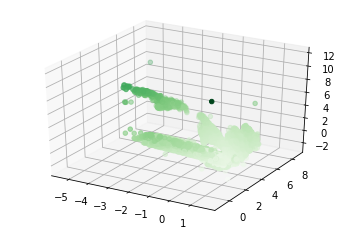

In [24]:
points_calculated_3d = np.array(points_calculated_3d)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(points_calculated_3d[:,0], points_calculated_3d[:,1], points_calculated_3d[:,2],
             c=points_calculated_3d[:,2], cmap='Greens');
# data = plt.imread(imfile)
# im = ax.imshow(data)
plt.show(fig)

In [ ]:
# Pass xyz to Open3D.o3d.geometry.PointCloud and visualize
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points_calculated_3d)
o3d.io.write_point_cloud("sync.ply", pcd)
# Load saved point cloud and visualize it
pcd_load = o3d.io.read_point_cloud("sync.ply")
o3d.visualization.draw_geometries([pcd_load])


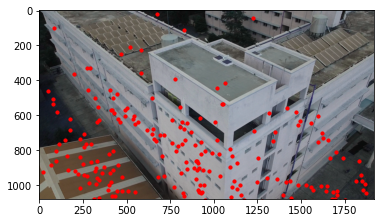

In [26]:
########### Project 3d points obtained from key points in this image back to the image and get reprojection error
proj_2d_points_ = []
reprojection_err_arr_ = []
points_calculated_3d = np.array(points_calculated_3d)
points_calculated_3d_homo = np.column_stack((points_calculated_3d, np.ones((points_calculated_3d.shape[0],1))))

for i in range(len(points_calculated_3d)):
#     proj_2d_points.append(K_imid@RT_imid@xyz_3dpoints[i])
#     point_2d_ = P_imid@xyz_3dpoints_homo[i]
    point_2d__ = P_imid[:3,:].astype(float)@points_calculated_3d_homo[i].astype(float)
    proj_2d_points_.append(point_2d__)
    point_2d_from_images_txt_ = np.array([keypoints_x_used[imid][i],keypoints_y_used[imid][i],1]).astype(float)
    #check if indices are properly mapped
    
#     reprojection_err_arr.append(np.linalg.norm(point_2d_ - point_2d_from_images_txt))
#     reprojection_err_arr.append(np.linalg.norm((point_2d_/point_2d_[2])[0:-1] - point_2d_from_images_txt[0:-1]))
    reprojection_err_arr_.append(np.linalg.norm(point_2d__ - point_2d_from_images_txt_))
    
# print(proj_2d_points)
proj_2d_points_ = np.array(proj_2d_points_)

fgp = plt.figure()
img_copy = copy.deepcopy(img)
plt.scatter(proj_2d_points_[:,0],proj_2d_points_[:,1],c='r', s=10)
impl = plt.imshow(img_copy)
plt.show()


In [27]:
# print(point_2d_)
# print(np.array(point_2d_from_images_txt)[0])
# print(np.array([keypoints_x_used[0],keypoints_y_used[0],1]))
# print(keypoints_x_used)
# print(type(xyz_3dpoints))

ind = 0
print('2d pixel coord: ',keypoints_x_used[imid][ind],keypoints_y_used[imid][ind])
print('3d coordinate: ',points_calculated_3d[ind])
print('3d point id: ',points_3d_ids.index(ind_list_3d_used_imid[ind]))

# print(len(reprojection_err_arr))
print('mean reproj err from calculation: ', np.mean(reprojection_err_arr_))
print('reprojection error in pixels from txt files: ', reproj_errs[imid])
# print(np.linalg.norm(np.mean(reprojection_err_arr) - float(reproj_errs[imid])))
print('difference: ',np.mean(reprojection_err_arr_) - float(reproj_errs[imid]))

2d pixel coord:  654.686 482.818
3d coordinate:  [ 0.24581477  2.511632   -0.42882743]
3d point id:  100762
mean reproj err from calculation:  3838.3354836084245
reprojection error in pixels from txt files:  0.0180835
difference:  3838.3174001084244


In [28]:
depth_arr

array([[4.2745085 , 4.2778344 , 4.259428  , ..., 4.145862  , 4.145947  ,
        4.1363792 ],
       [4.167064  , 4.1652713 , 4.162159  , ..., 4.12683   , 4.154067  ,
        4.140673  ],
       [4.1434264 , 4.1409793 , 4.138115  , ..., 4.1318717 , 4.199336  ,
        4.1839485 ],
       ...,
       [0.91584927, 0.9164903 , 0.91744465, ..., 1.6368525 , 4.1871605 ,
        6.5070376 ],
       [0.91557556, 0.92199755, 1.7697511 , ..., 1.6279279 , 1.579718  ,
        1.5187849 ],
       [0.91557527, 1.8088026 , 1.785162  , ..., 1.7145706 , 1.6856819 ,
        1.7152145 ]], dtype=float32)